In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class LSTMcell(object):
    def __init__(self, incoming, D_input, D_cell, initializer, f_bias=1.0):
        
        # var
        # the shape of incoming is [n_samples, n_steps, D_cell]
        self.incoming = incoming
        self.D_input = D_input
        self.D_cell = D_cell
        # parameters
          # igate = W_xi.* x + W_hi.* h + b_i
        self.W_xi = initializer([self.D_input, self.D_cell])
        self.W_hi = initializer([self.D_cell, self.D_cell])
        self.b_i  = tf.Variable(tf.zeros([self.D_cell]))  
          # fgate = W_xf.* x + W_hf.* h + b_f
        self.W_xf = initializer([self.D_input, self.D_cell])
        self.W_hf = initializer([self.D_cell, self.D_cell])
        self.b_f  = tf.Variable(tf.constant(f_bias, shape=[self.D_cell])) 
          # ogate = W_xo.* x + W_ho.* h + b_o
        self.W_xo = initializer([self.D_input, self.D_cell])
        self.W_ho = initializer([self.D_cell, self.D_cell])
        self.b_o  = tf.Variable(tf.zeros([self.D_cell])) 
          # cell = W_xc.* x + W_hc.* h + b_c
        self.W_xc = initializer([self.D_input, self.D_cell])
        self.W_hc = initializer([self.D_cell, self.D_cell])
        self.b_c  = tf.Variable(tf.zeros([self.D_cell]))  
        
        # init cell and hidden state whose shapes are [n_samples, D_cell]
        init_for_both = tf.matmul(self.incoming[:,0,:], tf.zeros([self.D_input, self.D_cell]))
        self.hid_init = init_for_both
        self.cell_init = init_for_both
        # because tf.scan only takes two arguments, the hidden state and cell are needed to merge
        self.previous_h_c_tuple = tf.stack([self.hid_init, self.cell_init])
        # transpose the tensor so that the first dim is time_step
        self.incoming = tf.transpose(self.incoming, perm=[1,0,2])
        
    def one_step(self, previous_h_c_tuple, current_x):
        
        # to split hidden state and cell
        prev_h, prev_c = tf.unstack(previous_h_c_tuple)
        
        # computing
        # input gate
        i = tf.sigmoid(
            tf.matmul(current_x, self.W_xi) + 
            tf.matmul(prev_h, self.W_hi) + 
            self.b_i)
        # forget Gate
        f = tf.sigmoid(
            tf.matmul(current_x, self.W_xf) + 
            tf.matmul(prev_h, self.W_hf) + 
            self.b_f)
        # output Gate
        o = tf.sigmoid(
            tf.matmul(current_x, self.W_xo) + 
            tf.matmul(prev_h, self.W_ho) + 
            self.b_o)
        # new cell info
        c = tf.tanh(
            tf.matmul(current_x, self.W_xc) + 
            tf.matmul(prev_h, self.W_hc) + 
            self.b_c)
        # current cell 
        current_c = f*prev_c + i*c
        # current hidden state
        current_h = o*tf.tanh(current_c)
        
        return tf.stack([current_h, current_c])
    
    def all_steps(self):
        # inputs shape : [n_sample, n_steps, D_input]
        # outputs shape : [n_steps, n_sample, D_output]
        hstates = tf.scan(fn = self.one_step,
                          elems = self.incoming,
                          initializer = self.previous_h_c_tuple,
                          name = 'hstates')[:,0,:,:]
        return hstates

In [3]:
def weight_init(shape):
    initial = tf.random_uniform(shape,minval=-np.sqrt(5)*np.sqrt(1.0/shape[0]), maxval=np.sqrt(5)*np.sqrt(1.0/shape[0]))
    return tf.Variable(initial,trainable=True)
def zero_init(shape):
    initial = tf.Variable(tf.zeros(shape))
    return tf.Variable(initial,trainable=True)
def orthogonal_initializer(shape,scale = 1.0):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
    scale = 1.0
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape) #this needs to be corrected to float32
    return tf.Variable(scale * q[:shape[0], :shape[1]],trainable=True, dtype=tf.float32)
def bias_init(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)
def shufflelists(data):
    ri=np.random.permutation(len(data))
    data=[data[i] for i in ri]
    return data
def Standardize(seq):
    #subtract mean
    centerized=seq-np.mean(seq, axis = 0)
    #divide standard deviation
    normalized=centerized/np.std(centerized, axis = 0)
    return normalized
mfc=np.load('X.npy')
art=np.load('Y.npy')
totalsamples=len(mfc)
vali_size=0.2
def data_prer(X, Y):
    D_input=X[0].shape[1]
    D_output=24
    data=[]
    for x,y in zip(X,Y):
        data.append([Standardize(x).reshape((1,-1,D_input)).astype("float32"),
                     Standardize(y).astype("float32")])
    return data
data=data_prer(mfc, art)
train=data[int(totalsamples*vali_size):]
test=data[:int(totalsamples*vali_size)]
print('num of train sequences:%s' %len(train))
print('num of test sequences:%s' %len(test))
print('shape of inputs:' ,test[0][0].shape)
print('shape of labels:' ,test[0][1].shape)

num of train sequences:83
num of test sequences:20
('shape of inputs:', (1, 886, 39))
('shape of labels:', (886, 24))


In [4]:
D_input = 39
D_label = 24
learning_rate = 7e-5
num_units=1024

inputs = tf.placeholder(tf.float32, [None, None, D_input], name="inputs")
labels = tf.placeholder(tf.float32, [None, D_label], name="labels")

rnn_cell = LSTMcell(inputs, D_input, num_units, orthogonal_initializer)
rnn0 = rnn_cell.all_steps()
# reshape for output layer
rnn = tf.reshape(rnn0, [-1, num_units])
# output layer
W = weight_init([num_units, D_label])
b = bias_init([D_label])
output = tf.matmul(rnn, W) + b

loss=tf.reduce_mean((output-labels)**2)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [5]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [6]:
# 训练并记录
def train_epoch(EPOCH):
    for k in range(EPOCH):
        train0=shufflelists(train)
        for i in range(len(train)):
            sess.run(train_step,feed_dict={inputs:train0[i][0],labels:train0[i][1]})
        tl=0
        dl=0
        for i in range(len(test)):
            dl+=sess.run(loss,feed_dict={inputs:test[i][0],labels:test[i][1]})
        for i in range(len(train)):
            tl+=sess.run(loss,feed_dict={inputs:train[i][0],labels:train[i][1]})
        print(k,'train:',round(tl/83,3),'test:',round(dl/20,3))

In [8]:
t0 = time.time()
train_epoch(10)
t1 = time.time()
print(" %f seconds" % round((t1 - t0),2))

(0, 'train:', 0.662, 'test:', 0.691)
(1, 'train:', 0.558, 'test:', 0.614)
(2, 'train:', 0.473, 'test:', 0.557)
(3, 'train:', 0.417, 'test:', 0.53)
(4, 'train:', 0.361, 'test:', 0.504)
(5, 'train:', 0.327, 'test:', 0.494)
(6, 'train:', 0.294, 'test:', 0.476)
(7, 'train:', 0.269, 'test:', 0.468)
(8, 'train:', 0.244, 'test:', 0.452)
(9, 'train:', 0.226, 'test:', 0.453)
 563.110000 seconds


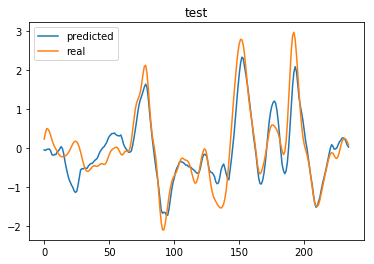

In [9]:
pY=sess.run(output,feed_dict={inputs:test[10][0]})
plt.plot(pY[:,8])
plt.plot(test[10][1][:,8])
plt.title('test')
plt.legend(['predicted','real'])

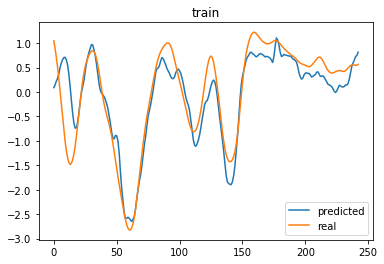

In [10]:
pY=sess.run(output,feed_dict={inputs:train[1][0]})
plt.plot(pY[:,6])
plt.plot(train[1][1][:,6])
plt.title('train')
plt.legend(['predicted','real'])